## EPR of networks

In [1]:
import os
import numpy as np
from tqdm import tqdm  # Import tqdm for the progress bar
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import scipy.io
from sklearn.decomposition import PCA

from scipy.signal import fftconvolve,convolve


In [2]:

# Set the number of threads for PyTorch
torch.set_num_threads(2)

# Define a neural network block with residual connections
class DeepRitzBlock(nn.Module):
    def __init__(self, h_size):
        super(DeepRitzBlock, self).__init__()
        # Define a sequential block with two linear layers and Tanh activations
        self.block = nn.Sequential(
            nn.Linear(h_size, h_size),
            nn.Tanh(),
            nn.Linear(h_size, h_size),
            nn.Tanh()
        )

    def forward(self, x):
        # Apply the block and add the input (residual connection)
        return self.block(x) + x

# Define a neural network model using DeepRitzBlock
class NeuralNetwork(nn.Module):
    def __init__(self, in_size, h_size=10, block_size=1, dev="cpu"):
        super(NeuralNetwork, self).__init__()
        self.dev = dev
        self.dim_input = in_size
        self.dim_h = h_size
        self.num_blocks = block_size

        # Initialize the layers list with either a linear layer or padding
        layers = [nn.ConstantPad1d((0, self.dim_h - self.dim_input), 0) if self.dim_input <= self.dim_h else
                  nn.Linear(self.dim_input, self.dim_h)]

        # Append DeepRitzBlock instances to the layers list
        for _ in range(self.num_blocks):
            layers.append(DeepRitzBlock(self.dim_h))

        # Add a final linear layer to map back to the input size
        layers.append(nn.Linear(self.dim_h, self.dim_input))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the model
        return self.model(x)

def generate_surrogate(x):
    x_surrogate = []
    for i, x_i in enumerate(x):
        x_surrogate_ = []
        for l in range(len(x_i)):
            fft_original = np.fft.rfft(x_i[l])
            magnitude = np.abs(fft_original)
            random_phases = np.exp(1j * np.random.uniform(0, 2 * np.pi, len(fft_original)))
            fft_random = magnitude * random_phases
            random_signal = np.fft.irfft(fft_random)
            x_surrogate_.append(random_signal)
        x_surrogate.append(np.array(x_surrogate_))
    return x_surrogate
#function for epr estimation
def EPR_nn_est_params(data_, dt, epoch_max=3000, step_test=100, data_normalisation=True,
                      reverse_training=False, dim_h=10, num_blocks=2):
    data_ij = data_
    dim, length = data_ij.shape
  

    if reverse_training:
        xt = torch.Tensor(data_ij[:, length // 2:].T)
        xt_test = torch.Tensor(data_ij[:, :length // 2].T)
    else:
        xt = torch.Tensor(data_ij[:, :length // 2].T)
        xt_test = torch.Tensor(data_ij[:, length // 2:].T)

    dim_x = dim
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    force_network = NeuralNetwork(dim_x, dim_h, num_blocks, dev).to(dev)
    print('device used:',dev)
    #M: change device if cuda is available
    xt = xt.to(dev)
    xt_test = xt_test.to(dev)

    data = xt - torch.mean(xt, dim=0)
    if data_normalisation:
        data /= torch.std(data, dim=0)

    data_mid = 0.5 * (data[1:, :] + data[:-1, :])
    xdiff = data[1:, :] - data[:-1, :]

    optimizer = torch.optim.Adadelta(force_network.parameters(), lr=1e-2)
    All_loss_train = []
    print('training')
    for epoch in tqdm(range(epoch_max), total=epoch_max):
        force_network.train()
        optimizer.zero_grad()
        dxmid = force_network(data_mid)
        jj = torch.sum(dxmid * xdiff, dim=1)
        loss = -2 * torch.mean(jj) ** 2 / (dt * torch.var(jj))
        loss.backward()
        optimizer.step()

        if epoch % step_test == 0:
            torch.save(force_network.state_dict(), f'saved_params/force_network_params_epoch_{epoch}.pt')
            All_loss_train.append(-loss.item())

    saved_params_dir = 'saved_params'
    steps = tqdm(range(0, epoch_max, step_test), total=epoch_max/step_test)
    test_losses = []

    data_test = xt_test - torch.mean(xt_test, dim=0)
    if data_normalisation:
        data_test /= torch.std(data_test, dim=0)

    data_mid_test = 0.5 * (data_test[1:, :] + data_test[:-1, :])
    xdiff_test = data_test[1:, :] - data_test[:-1, :]

    print('testing')
    for step in steps:
        param_file = os.path.join(saved_params_dir, f'force_network_params_epoch_{step}.pt')
        if os.path.exists(param_file):
            force_network.load_state_dict(torch.load(param_file))
            force_network.eval()
            with torch.no_grad():
                dxmid_test = force_network(data_mid_test)
                jj_test = torch.sum(dxmid_test * xdiff_test, dim=1)
                loss_test = -2 * torch.mean(jj_test) ** 2 / (dt * torch.var(jj_test))
                test_losses.append(-loss_test.item())
        else:
            test_losses.append(None)

    epr_train, epr_test = np.max(All_loss_train), np.max(test_losses)
    print(f"Maximum EPR on training data: {epr_train}")
    print(f"Maximum EPR on test data: {epr_test}")

    return test_losses, All_loss_train



In [3]:
#load network-activity data
cd = os.getcwd()

Im_on_server = True #change directories for loading and saving, depending on system

filename = 'pop-spikes_ff15_seed42_setupA1.npy' #'pop-spikes_num-exc12_num-inh3_seed42_test1.npy'
if Im_on_server:
    pop_sp_times = np.load(cd + '/saved_activities/feed forward/'+ filename)
else:
    pop_sp_times = np.load(cd + '\\saved_activities\\'+ filename)

#extract dimensions etc of dataset
times, id_neuron = pop_sp_times[0], pop_sp_times[1]
num_neurons = np.unique(id_neuron).size
T_is_unknown = False
if T_is_unknown:
    T = np.max(times) #ms
else:
    T = 100000 #ms #TODO: always check, whether T is up to date
num_exc, num_inh = 15, 0


#set params
dt = 1 #ms #choose bin/ tp width; simulation time-step is 0.1 ms
tau = 10 #ms time-constant of exp filt (check if used)
filter_width = 10 #ms #kernel width for smoothing spike-train for epr-algo
num_tp = int(T/dt) 
print('Num neurons:',num_neurons, ', Num time-points:', num_tp, ', duration:',num_tp*dt,' ms')

#define func for binning spike-times
def bin_tp_data(tp_data, T, dt):
    all_tps = tp_data[0]
    neuron_ind = tp_data[1]
    N = np.unique(neuron_ind).size
    nbins = int(T/dt)

    time_bins = np.arange(0,T+dt, dt) #T+dt includes right most edge of last bin -> T is last value -> no spike is missed as T is end of simulation
    binned_data = np.zeros([N, nbins])
    for ni in range(N):
        indices = tp_data[1]
        tps = all_tps[indices == ni] #for each neuron_id, take only time points that belong to it

        binned_data[ni], _ = np.histogram(tps, bins = time_bins)

    return time_bins, binned_data
#define functions for filtering spike-train (easier to interpret for epr algorithm)
def gauss(x, mean=0,width=5,max=1): #TODO: choose width wisely
    return max * np.exp(-0.5*((x-mean)/width)**2)

from scipy.ndimage import gaussian_filter1d
#filter with gaussian
def inst_rate(data, filter_width = 5, dt=1): #TODO: add kernel params
    sigma_bins = filter_width / dt  # std in bins
    inst_rate = gaussian_filter1d(data.astype(float), sigma=sigma_bins, axis=1, mode='constant')
    inst_rate *= np.sqrt(2 * np.pi) * sigma_bins
    return inst_rate

#filter with exponential
def expfilt(x, tau, height=1, dt=1):
    '''for plotting of filter'''
    ntp = x.size
    half_ntp = ntp//2
    kernel = np.exp(-x / (tau/dt)) * height
    kernel[:half_ntp] = np.zeros([half_ntp])   
    return kernel

def inst_rate_exp(data, tau=10, height=1, dt=1, axis=-1):
    """
    Symmetric exponential smoothing along a given axis.
    tau: decay parameter (higher = wider smoothing).
    """
    # Kernel length: ~6*tau to capture most mass
    ndim, ntp = data.shape
    half_ntp = ntp//2
    x = np.linspace(-half_ntp, half_ntp, ntp)
    kernel = np.exp(-np.abs(x) / (tau/dt)) * height
    kernel[:half_ntp] = np.zeros([half_ntp])
    #kernel /= kernel.sum()
    
    return convolve(data, kernel[np.newaxis], mode="same", method='auto') #[np.newaxis]

#bin spike-times
time_bins, binned_spikes = bin_tp_data(pop_sp_times, T=T, dt=dt)

#get rate by filtering spike-train
pop_sprate = inst_rate_exp(binned_spikes, tau = tau, dt=dt)  #exp filter
#pop_sprate = inst_rate(binned_spikes, filter_width= filter_width, dt=dt)  #gaussian filter

#extract inhibitory and excitatiory neurons (in case needed)
pop_sprate_inh = pop_sprate[num_exc:]
pop_sprate_exc = pop_sprate[:num_exc]



Num neurons: 15 , Num time-points: 100000 , duration: 100000  ms


mean fano-factors: 0.9423373333333334 for data, and  0.944786 for model


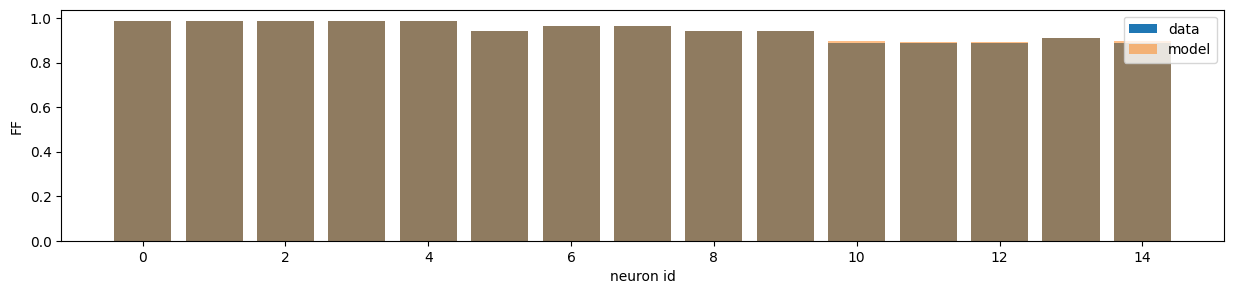

In [4]:
#build null-model (shuffle IsIs); needs spike-times
np.random.seed(42)

def shuffle_isi(spikes):
    spikesH0 = np.zeros([*spikes.shape])
    sp_timesH0, sp_neuronH0 = spikes[0], spikes[1] #shuf_test[0], shuf_test[1]
    num_neurons = np.unique(sp_neuronH0).size

    level = 0
    for i_neuron in range(num_neurons):#shuffle individually for each neuron; or should I just shuffle the neuron's indices?
        times = sp_timesH0[sp_neuronH0==i_neuron]
        #include time 0 for propper shuffling of isis
        if times[0]==0: #...except for the case, where 1st time is 0 already; TODO does size match then?
            isis = np.diff(times)
            print('spike at time 0 for neuron {}; shuffling might not be entirely random in that case'.format(i_neuron))
        else:
            times0 = np.zeros([times.size+1]) 
            times0[1:] = times
            #get isis
            isis = np.diff(times0)
        #shuffle isis
        np.random.shuffle(isis)
        shuffled_times = np.cumsum(isis) #get new timepoints from shuffled isis
        #print(times.size==shuffled_times.size)
        #add to new spike array
        nspikes_neuron_i = times.size
        spikesH0[0, level : level+nspikes_neuron_i] = shuffled_times
        spikesH0[1, level : level+nspikes_neuron_i] = np.repeat(i_neuron, nspikes_neuron_i)
        level+= nspikes_neuron_i 
    #sort array by ascending spike-times
    spikesH0 = spikesH0[:,spikesH0[0,:].argsort()]
    return spikesH0
#spikesH0 = shuffle_isi(pop_sp_times)
# #bin
# print('binning...')
# time_bins, binned_spikesH0 = bin_tp_data(spikesH0, T=T, dt=dt)
# #filter
# print('filtering...')
# pop_sprateH0 = inst_rate(binned_spikesH0, filter_width= filter_width, dt=dt)

def Poisson_model(binned_spikes): #TODO: check fano factor, for > 1 spike/per_bin
    '''takes the rates of each neuron over the whole trajectory and generates new
    trajectory from poisson-process. EPR should be close to 0 -> negative ctrl'''
    nNeurons, nbins = binned_spikes.shape
    rates = binned_spikes.sum(axis=1) #spikes/T -> np's poisson takes no time-interval, so it needs to be in rate
    nspikes = np.random.poisson(rates)

    pois_model = np.zeros([*binned_spikes.shape])
    for ni in range(nNeurons):
        rn_ind = np.random.randint(0, nbins, nspikes[ni])
        pois_model[ni, rn_ind] = 1 
    #check, whether data binomial
    if np.any(binned_spikes>1)|np.any(pois_model>1):
        print('Warning: data wasnt bernoulli/binary due to binning, so Fano-factor might be incorrect')

    mean_data, mean_pois = np.mean(binned_spikes, axis=1), np.mean(pois_model, axis=1)
    var_data, var_pois = mean_data*(1 - mean_data), mean_pois*(1 - mean_pois)

    FF_data = var_data/mean_data
    FF_model = var_pois/mean_pois

    print('mean fano-factors:', np.mean(FF_data), 'for data, and ', np.mean(FF_model), 'for model')
    plt.figure(figsize=(15,3))
    plt.bar(np.arange(nNeurons), FF_data,label='data')
    plt.bar(np.arange(nNeurons), FF_model,label='model',alpha = 0.5)
    plt.ylabel('FF')
    plt.xlabel('neuron id')
    plt.legend()
    return pois_model


pois_mod = Poisson_model(binned_spikes)
pois_mod_rate = inst_rate_exp(pois_mod, tau = tau, dt=dt)#inst_rate(pois_mod, filter_width, dt)

#plt.plot(spikesH0[0], spikesH0[1], 's', markersize=1)

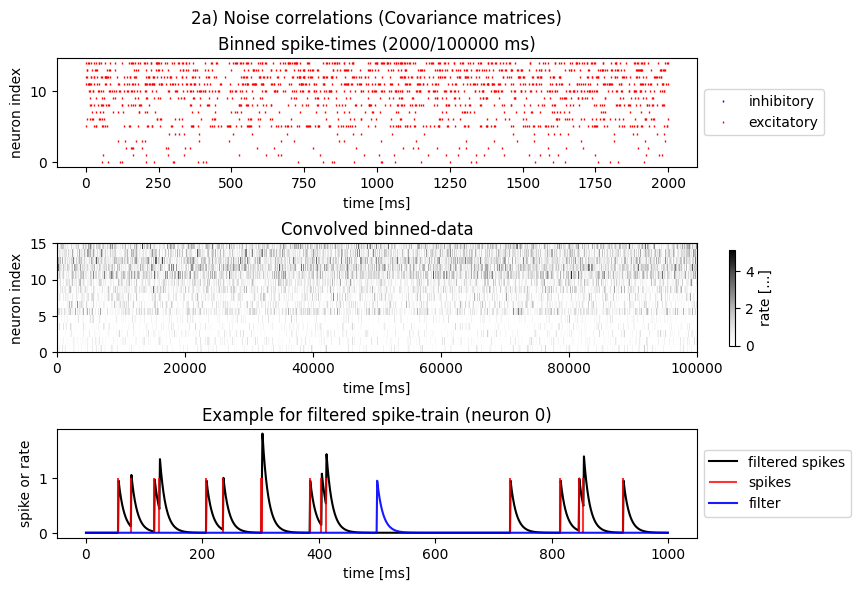

In [5]:
#visualize data
binned_sp = pois_mod#np.hstack((pop_sprate, pop_sprate41))
pop_rate = pois_mod_rate

#plot binned spikes data
fig,ax = plt.subplots(3)

plot_to_time = 2000 #ms
plot_to = plot_to_time//dt #bins
markersize =1
ax[0].set_title('Binned spike-times ({}/{} ms)'.format(plot_to_time, T))
nidx, tp = np.nonzero(binned_sp[:, :plot_to]) #as arrays are too big and sparse for imshow visualization, extract non-zero element's indices
nidx_inh, tp_inh = nidx[nidx>=num_exc], tp[nidx>=num_exc] #divide into indices for inhibitory
nidx_exc, tp_exc = nidx[nidx<num_exc], tp[nidx<num_exc] #and exc
ax[0].plot(tp_inh*dt, nidx_inh,'|', markersize=markersize, color='blue', label='inhibitory')
ax[0].plot(tp_exc*dt, nidx_exc,'|', markersize=markersize, color='red', label = 'excitatory')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_xlabel('time [ms]')
ax[0].set_ylabel('neuron index')

#plot convolved binned spikes
ax[1].set_title('Convolved binned-data')
 #for visualization, where we plot inh and exc in different colors, make inh rates negative
im = ax[1].imshow(pop_rate, aspect='auto', origin='lower',interpolation='none', cmap='Greys', extent=[0, T, 0, num_neurons]) # activity
ax[1].set_ylabel('neuron index')
ax[1].set_xlabel('time [ms]')
plt.tight_layout()

#plot convolved spike-train for example neuron
plot_to_time = 1000 #ms
plot_to = plot_to_time//dt #bins
ix = 0
ntp = time_bins[:-1].size
ax[2].set_title('Example for filtered spike-train (neuron {})'.format(ix))
ax[2].plot(time_bins[:plot_to], pop_rate[ix, :plot_to], 'black',label='filtered spikes')
example_spike_inds = np.nonzero(binned_sp[ix, :plot_to])
ax[2].vlines(example_spike_inds, 0, np.ones([len(example_spike_inds)]), color='red', label='spikes', alpha=0.8)
ax[2].plot(time_bins[:plot_to], expfilt(np.linspace(-plot_to//2, plot_to//2, plot_to), tau = tau, dt=dt), 'blue',alpha=0.9, label='filter')
#ax[2].plot(time_bins[:plot_to], gauss(np.linspace(-plot_to//2, plot_to//2, plot_to), width = filter_width/dt), 'blue',alpha=0.99, label='filter')
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2].set_ylabel('spike or rate')
ax[2].set_xlabel('time [ms]')

cbar_ax = fig.add_axes([1.05, 0.4, 0.01, 0.2])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='vertical')
cbar.set_label('rate [...]')
#ax[0]. #TODO: add colorbar
plt.suptitle('2a) Noise correlations (Covariance matrices)',y=1.1)
fig.subplots_adjust(0,0,1,1,0.5,0.7)


In [19]:
#make epr func that does several runs on single time-series -> average for stable epr estimate
def multi_epr_est(num_runs, time_series, dt=1, epoch_max=20000, step_test=100, reverse_training=False, data_normalisation=True, dim_h=5, num_blocks=2):
    num_steps = int(epoch_max/step_test)
    all_sig_train = np.zeros([num_runs, num_steps])
    print(int(epoch_max/step_test))
    all_sig_test = np.zeros([num_runs, num_steps])
    #run EPR-algo
    for run in range(num_runs):
        print('run nr.:', run,'/',num_runs)
        test_losses, All_loss_train = EPR_nn_est_params(time_series, dt=dt, epoch_max=epoch_max, step_test=step_test, reverse_training=reverse_training, data_normalisation=data_normalisation, dim_h=dim_h, num_blocks=num_blocks)
        
        all_sig_train[run] = All_loss_train #epr estimation over epochs
        all_sig_test[run] = test_losses

        #plot train/test EPR over epochs; to check convergence in the runs
    fig,ax = plt.subplots(2, sharex=True)
    test_array = np.arange(0, epoch_max, step_test)
    av_sig_test = all_sig_test.mean(0)
    ax[0].plot(test_array,all_sig_test.T)
    ax[0].plot(test_array, av_sig_test, color='black', label ='average', linewidth = 2)
    ax[0].grid(axis ='y', which='major')
    ax[0].set_title('Test-epr over epochs')
    ax[0].set_xlabel('epoch')
    ax[0].tick_params(axis='y', which='major', labelsize=10)
    ax[0].set_ylabel('EPR ['r'$k_B/s$'']')
    ax[0].set_yscale('log')
    ax[0].legend()

    av_sig_train = all_sig_train.mean(0)
    ax[1].plot(test_array, all_sig_train.T) #TODO check why training was sampled with steptest!
    ax[1].plot(test_array, av_sig_train, color='black', label ='average', linewidth = 2)
    ax[1].grid(axis ='y', which='major')
    ax[1].set_title('Test-epr over epochs')
    ax[1].set_xlabel('epoch')
    ax[1].tick_params(axis='y', which='major', labelsize=10)
    ax[1].set_ylabel('EPR ['r'$k_B/s$'']')
    ax[1].set_yscale('log')
    ax[1].legend()
    #ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    return all_sig_test, all_sig_train


Current Working Directory: /home/michael_lmu/EPR
200
run nr.: 0 / 3
device used: cuda
training


  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [01:30<00:00, 220.44it/s]
 10%|▉         | 19/200.0 [00:00<00:00, 188.26it/s]

testing


100%|██████████| 200/200.0 [00:00<00:00, 206.75it/s]


Maximum EPR on training data: 2.254283905029297
Maximum EPR on test data: 2.340437650680542
run nr.: 1 / 3
device used: cuda
training


100%|██████████| 20000/20000 [01:31<00:00, 219.41it/s]
 10%|█         | 20/200.0 [00:00<00:00, 191.69it/s]

testing


100%|██████████| 200/200.0 [00:00<00:00, 205.24it/s]


Maximum EPR on training data: 2.470492362976074
Maximum EPR on test data: 2.4550182819366455
run nr.: 2 / 3
device used: cuda
training


100%|██████████| 20000/20000 [01:32<00:00, 216.34it/s]
 10%|▉         | 19/200.0 [00:00<00:00, 189.32it/s]

testing


100%|██████████| 200/200.0 [00:00<00:00, 206.39it/s]


Maximum EPR on training data: 2.95851469039917
Maximum EPR on test data: 2.9548397064208984


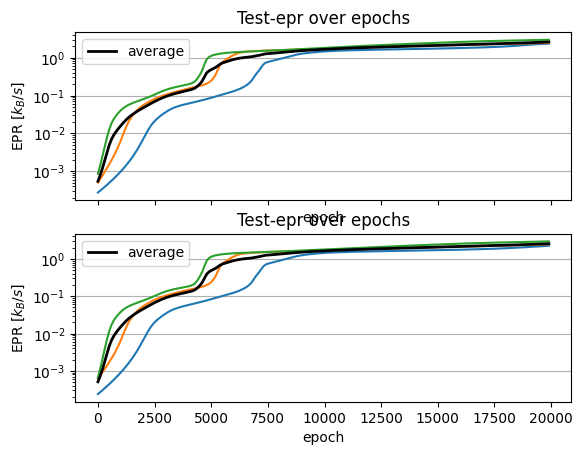

In [21]:
# estimate epr of time series
run_control = False
if run_control:
    time_series = pois_mod_rate#pop_sprate 
    binned_sp = pois_mod#binned_spikes
else:
    time_series = pop_sprate 
    binned_sp = binned_spikes

# Change the current working directory: IN WHICH YOU HAVE A FOLDER NAMED "saved_params"
os.chdir(cd) #Users/pascal.helson/Documents/PYTHON/testing_code')#
# Verify the change
print("Current Working Directory:", cd)


# Setting parameters
working_params=False
epoch_max, step_test, dim_h, num_blocks = 20000, 100, 5, 2
if working_params ==True:
    epoch_max, step_test, dim_h, num_blocks = 1000, 10, 5, 1 #working params
#run EPR-algo
# test_losses, All_loss_train = EPR_nn_est_params(time_series, dt=dt,
#                     epoch_max=epoch_max, step_test=step_test, reverse_training=False, data_normalisation=False, dim_h=dim_h, num_blocks=num_blocks)
all_sig_test, all_sig_train = multi_epr_est(num_runs=3, time_series = time_series, dt=dt,
                epoch_max=epoch_max, step_test=step_test, reverse_training=False, data_normalisation=False, dim_h=dim_h, num_blocks=num_blocks )

#average over runs
sigma_test = all_sig_test.mean(axis=0) #epr estimation over epochs
sigma_train = all_sig_train.mean(axis=0)
test_array = np.arange(0, epoch_max, 1)



In [29]:
#save results:
save = True

if save:
    results = {'trajectory':time_series, 'EPR_train':sigma_train, 'EPR_test':sigma_test}
    file_name = 'pop15_ff_setupA1_pois-ctrl_epr1_dt{}_expflt{}_norm__epochmax{}_dimh{}_numblocks{}'.format(dt, tau, epoch_max, dim_h, num_blocks)
    
    if Im_on_server:
        path = cd + '/saved_results/network epr/feed-forward epr/'
    else:
        path = cd + '\\saved_results\\network epr\\' 

    np.save(path + file_name, results)

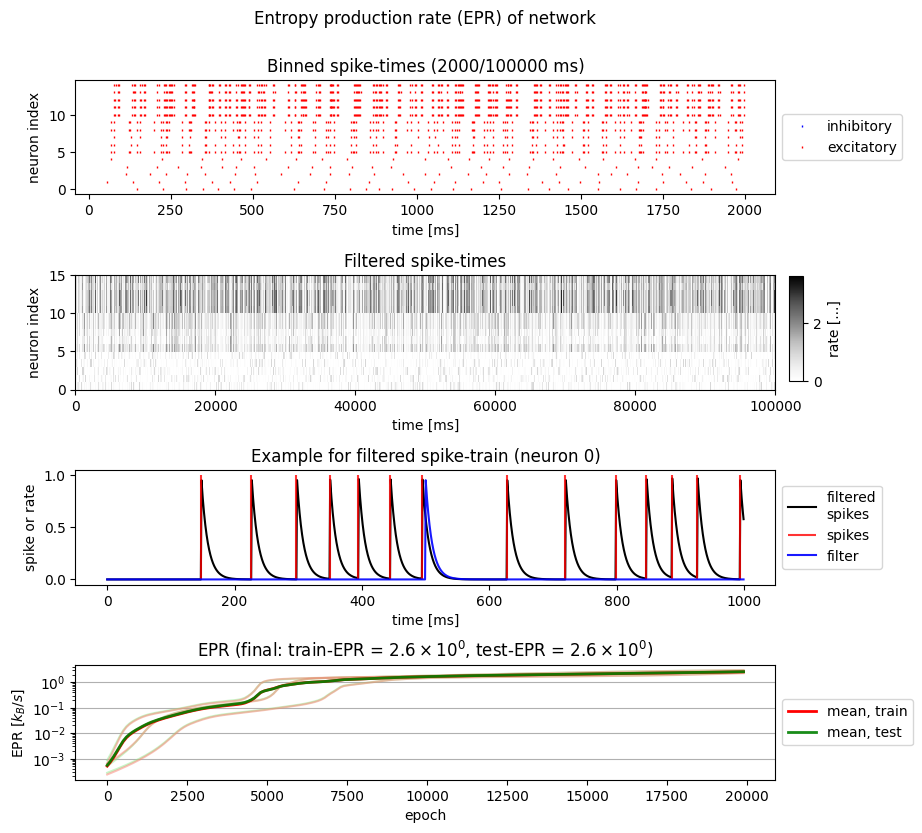

In [26]:
#plot results
fig, ax = plt.subplots(4,1,figsize=(7,7))

#plot binned spikes data
plot_to_time = 2000 #ms
plot_to = plot_to_time//dt #bins
markersize =1
ax[0].set_title('Binned spike-times ({}/{} ms)'.format(plot_to_time, T))
nidx, tp = np.nonzero(binned_sp[:, :plot_to]) #as arrays are too big and sparse for imshow visualization, extract non-zero element's indices
nidx_inh, tp_inh = nidx[nidx>=num_exc], tp[nidx>=num_exc] #divide into indices for inhibitory
nidx_exc, tp_exc = nidx[nidx<num_exc], tp[nidx<num_exc] #and exc
ax[0].plot(tp_inh*dt, nidx_inh,'|', markersize=markersize, color='blue', label='inhibitory')
ax[0].plot(tp_exc*dt, nidx_exc,'|', markersize=markersize, color='red', label = 'excitatory')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_xlabel('time [ms]')
ax[0].set_ylabel('neuron index')

#plot convolved binned spikes
ax[1].set_title('Filtered spike-times')
im1 = ax[1].imshow(time_series, aspect='auto', origin='lower', cmap='Greys', interpolation='none', extent = [0, T, 0, num_neurons])#np.arange(ntp), np.arange(ndim),data, cmap='Greys')
ax[1].set_xlabel('time [ms]')
ax[1].set_ylabel('neuron index')

def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """Return number in scientific notation as LaTeX string."""
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is not None:
        coeff = f"{coeff:.{precision}f}"
    return r"${} \times 10^{{{}}}$".format(coeff, exponent)

#plot convolved spike-train for example neuron
plot_to_time = 1000 #ms
plot_to = plot_to_time//dt #bins
ix = 0
ntp = time_bins[:-1].size
ax[2].set_title('Example for filtered spike-train (neuron {})'.format(ix))
ax[2].plot(time_bins[:plot_to], time_series[ix, :plot_to], 'black',label='filtered\nspikes')
example_spike_inds = np.nonzero(binned_sp[ix, :plot_to])
ax[2].vlines(example_spike_inds, 0, np.ones([len(example_spike_inds)]), color='red', label='spikes', alpha=0.8)
ax[2].plot(time_bins[:plot_to], expfilt(np.linspace(-plot_to//2, plot_to//2, plot_to), tau = tau, dt=dt), 'blue',alpha=0.9, label='filter')
#ax[2].plot(time_bins[:plot_to], gauss(np.linspace(-plot_to//2, plot_to//2, plot_to), width = filter_width/dt), 'blue',alpha=0.99, label='filter')
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2].set_ylabel('spike or rate')
ax[2].set_xlabel('time [ms]')


#plot train/test EPR over epochs
ax[3].plot(test_array[::step_test],all_sig_test.T, alpha=0.5, color = 'lightgreen')
ax[3].plot(test_array[::step_test], all_sig_train.T, alpha=0.5, color = 'salmon')
ax[3].plot(test_array[::step_test], all_sig_train.mean(0), color='red', lw=2, label='mean, train')
ax[3].plot(test_array[::step_test], all_sig_test.mean(0), color='green', lw=2, label='mean, test',alpha=0.9)
ax[3].grid(axis ='y', which='major')
train_array = np.arange(0,epoch_max,1)
ax[3].set_yscale('log')
#ax[2].text(0,epoch_max,'final EPRs:\ntraining: {}\ntesting: {}'.format(sci_notation(sigma_train[-1]), sci_notation(sigma_test[-1])))
#ax[2].set_yticks([10e-4,10e-3,0.10e-2,10e-1,10e0,10e1,10e2,10e3,10e4,10e5, 10e6])
#ax[2].set_ylim(10e-4,10e6)
ax[3].tick_params(axis='y', which='major', labelsize=10)
ax[3].set_title('EPR (final: train-EPR = {}, test-EPR = {})'.format(sci_notation(sigma_train[-1]), sci_notation(sigma_test[-1])))
ax[3].set_xlabel('epoch')
ax[3].set_ylabel('EPR ['r'$k_B/s$'']')
#ax[1].set_title
ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle("Entropy production rate (EPR) of network", y=1.1)
#add colorbar and determine plot spacing and size
cbar_ax = fig.add_axes([1.02, 0.57, 0.02, 0.15])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
cbar.set_label('rate [...]')
fig.subplots_adjust(0,0,1,1,0.5,0.7)
plt.show()


NameError: name 'rate' is not defined